In [1]:
df = spark.createDataFrame([
        (1, 144.5, 5.9, 33, 'M'),
        (2, 167.2, 5.4, 45, 'M'),
        (3, 124.1, 5.2, 23, 'F'),
        (4, 144.5, 5.9, 33, 'M'),
        (5, 133.2, 5.7, 54, 'F'),
        (3, 124.1, 5.2, 23, 'F'),
        (5, 129.2, 5.3, 42, 'M'),
    ], ['id', 'weight', 'height', 'age', 'gender'])

In [2]:
print('Count of rows: {0}'.format(df.count()))
print('Count of distinct rows: {0}'.format(df.distinct().count()))

Count of rows: 7
Count of distinct rows: 6


In [3]:
df = df.dropDuplicates()

In [4]:
df.show()

+---+------+------+---+------+
| id|weight|height|age|gender|
+---+------+------+---+------+
|  5| 133.2|   5.7| 54|     F|
|  5| 129.2|   5.3| 42|     M|
|  1| 144.5|   5.9| 33|     M|
|  4| 144.5|   5.9| 33|     M|
|  2| 167.2|   5.4| 45|     M|
|  3| 124.1|   5.2| 23|     F|
+---+------+------+---+------+



In [5]:
print('Count of ids: {0}'.format(df.count()))
print('Count of distinct ids: {0}'.format(
df.select([
    c for c in df.columns if c != 'id'
]).distinct().count()))

Count of ids: 6
Count of distinct ids: 5


In [6]:
df = df.dropDuplicates(subset=[
    c for c in df.columns if c != 'id'
])

In [7]:
df.show()

+---+------+------+---+------+
| id|weight|height|age|gender|
+---+------+------+---+------+
|  5| 133.2|   5.7| 54|     F|
|  1| 144.5|   5.9| 33|     M|
|  2| 167.2|   5.4| 45|     M|
|  3| 124.1|   5.2| 23|     F|
|  5| 129.2|   5.3| 42|     M|
+---+------+------+---+------+



In [8]:
import pyspark.sql.functions as fn

df.agg(
    fn.count('id').alias('count'),
    fn.countDistinct('id').alias('distinct')
).show()

+-----+--------+
|count|distinct|
+-----+--------+
|    5|       4|
+-----+--------+



In [9]:
df.withColumn('new_id',fn.monotonically_increasing_id()).show()

+---+------+------+---+------+-------------+
| id|weight|height|age|gender|       new_id|
+---+------+------+---+------+-------------+
|  5| 133.2|   5.7| 54|     F|  25769803776|
|  1| 144.5|   5.9| 33|     M| 171798691840|
|  2| 167.2|   5.4| 45|     M| 592705486848|
|  3| 124.1|   5.2| 23|     F|1236950581248|
|  5| 129.2|   5.3| 42|     M|1365799600128|
+---+------+------+---+------+-------------+



df_miss = spark.createDataFrame([
        (1, 143.5, 5.6, 28,   'M',  100000),
        (2, 167.2, 5.4, 45,   'M',  None),
        (3, None , 5.2, None, None, None),
        (4, 144.5, 5.9, 33,   'M',  None),
        (5, 133.2, 5.7, 54,   'F',  None),
        (6, 124.1, 5.2, None, 'F',  None),
        (7, 129.2, 5.3, 42,   'M',  76000),
    ], ['id', 'weight', 'height', 'age', 'gender', 'income'])

In [10]:

df_miss = spark.createDataFrame([
        (1, 143.5, 5.6, 28,   'M',  100000),
        (2, 167.2, 5.4, 45,   'M',  None),
        (3, None , 5.2, None, None, None),
        (4, 144.5, 5.9, 33,   'M',  None),
        (5, 133.2, 5.7, 54,   'F',  None),
        (6, 124.1, 5.2, None, 'F',  None),
        (7, 129.2, 5.3, 42,   'M',  76000),
    ], ['id', 'weight', 'height', 'age', 'gender', 'income'])

In [11]:
df_miss.rdd.map(
    lambda row: (row['id'], sum([c == None for c in row]))
).collect()

[(1, 0), (2, 1), (3, 4), (4, 1), (5, 1), (6, 2), (7, 0)]

### 欠落値のパーセンテージを調べる

In [12]:
df_miss.agg(*[
    (1 - (fn.count(c) / fn.count('*'))).alias(c + '_missing')
    for c in df_miss.columns
]).show()

+----------+------------------+--------------+------------------+------------------+------------------+
|id_missing|    weight_missing|height_missing|       age_missing|    gender_missing|    income_missing|
+----------+------------------+--------------+------------------+------------------+------------------+
|       0.0|0.1428571428571429|           0.0|0.2857142857142857|0.1428571428571429|0.7142857142857143|
+----------+------------------+--------------+------------------+------------------+------------------+



In [13]:
df_miss_no_income = df_miss.select([
    c for c in df_miss.columns if c != 'income'
])

In [14]:
df_miss_no_income.collect()

[Row(id=1, weight=143.5, height=5.6, age=28, gender='M'),
 Row(id=2, weight=167.2, height=5.4, age=45, gender='M'),
 Row(id=3, weight=None, height=5.2, age=None, gender=None),
 Row(id=4, weight=144.5, height=5.9, age=33, gender='M'),
 Row(id=5, weight=133.2, height=5.7, age=54, gender='F'),
 Row(id=6, weight=124.1, height=5.2, age=None, gender='F'),
 Row(id=7, weight=129.2, height=5.3, age=42, gender='M')]

In [15]:
df_miss_no_income.dropna(thresh=3).show()

+---+------+------+----+------+
| id|weight|height| age|gender|
+---+------+------+----+------+
|  1| 143.5|   5.6|  28|     M|
|  2| 167.2|   5.4|  45|     M|
|  4| 144.5|   5.9|  33|     M|
|  5| 133.2|   5.7|  54|     F|
|  6| 124.1|   5.2|null|     F|
|  7| 129.2|   5.3|  42|     M|
+---+------+------+----+------+



In [16]:
means = df_miss_no_income.agg(
    *[fn.mean(c).alias(c)
     for c in df_miss_no_income.columns if c != 'gender']
).toPandas().to_dict('records')[0]

means['gender'] = 'missing'

df_miss_no_income.fillna(means).show()

+---+------------------+------+---+-------+
| id|            weight|height|age| gender|
+---+------------------+------+---+-------+
|  1|             143.5|   5.6| 28|      M|
|  2|             167.2|   5.4| 45|      M|
|  3|140.28333333333333|   5.2| 40|missing|
|  4|             144.5|   5.9| 33|      M|
|  5|             133.2|   5.7| 54|      F|
|  6|             124.1|   5.2| 40|      F|
|  7|             129.2|   5.3| 42|      M|
+---+------------------+------+---+-------+



In [17]:
df_outliers = spark.createDataFrame([
        (1, 143.5, 5.3, 28),
        (2, 154.2, 5.5, 45),
        (3, 342.3, 5.1, 99),
        (4, 144.5, 5.5, 33),
        (5, 133.2, 5.4, 54),
        (6, 124.1, 5.1, 21),
        (7, 129.2, 5.3, 42),
    ], ['id', 'weight', 'height', 'age'])

### .approxQuantile(...)を使ってそれぞれの列に対して上限と下限を計算する

In [18]:
cols = ['weight', 'height', 'age']
bounds = {}

for col in cols:
    quantiles = df_outliers.approxQuantile(
        col, [0.25,0.75],0.05
    )
    IQR = quantiles[1] - quantiles[0]
    bounds[col] = [
        quantiles[0] - 1.5 * IQR,
        quantiles[1] - 1.5 * IQR
    ]

In [19]:
print(bounds)

{'weight': [91.69999999999999, 116.69999999999999], 'height': [4.499999999999999, 4.8999999999999995], 'age': [-11.0, 15.0]}


In [20]:

outliers = df_outliers.select(*['id'] + [
    (
        (df_outliers[c] < bounds[c][0]) | 
        (df_outliers[c] > bounds[c][1])
    ).alias(c + '_o') for c in cols
])
outliers.show()

+---+--------+--------+-----+
| id|weight_o|height_o|age_o|
+---+--------+--------+-----+
|  1|    true|    true| true|
|  2|    true|    true| true|
|  3|    true|    true| true|
|  4|    true|    true| true|
|  5|    true|    true| true|
|  6|    true|    true| true|
|  7|    true|    true| true|
+---+--------+--------+-----+



In [21]:
import pyspark.sql.types as typ

fraud = sc.textFile('ccFraud.csv.gz')
header = fraud.first()

##　ヘッダ行を取り除く
##　カンマごとに分割しそれぞれの要素を整数に変換する
fraud = fraud\
.filter(lambda row: row != header)\
.map(lambda row: [int(elem) for elem in row.split(',')])

# DataFrameのスキーマを作成
fields = [
    *[
        typ.StructField(h[1:-1], typ.IntegerType(), True)
        for h in header.split(',')
    ]
]
schema = typ.StructType(fields)

In [22]:
fraud_df = spark.createDataFrame(fraud,schema)

In [23]:
fraud_df.printSchema()

root
 |-- custID: integer (nullable = true)
 |-- gender: integer (nullable = true)
 |-- state: integer (nullable = true)
 |-- cardholder: integer (nullable = true)
 |-- balance: integer (nullable = true)
 |-- numTrans: integer (nullable = true)
 |-- numIntlTrans: integer (nullable = true)
 |-- creditLine: integer (nullable = true)
 |-- fraudRisk: integer (nullable = true)



In [24]:
fraud_df.groupby('gender').count().show()

+------+-------+
|gender|  count|
+------+-------+
|     1|6178231|
|     2|3821769|
+------+-------+



In [25]:
numerical = ['balance','numTrans','numIntlTrans']

In [26]:
desc = fraud_df.describe(numerical)
desc.show()

+-------+-----------------+------------------+-----------------+
|summary|          balance|          numTrans|     numIntlTrans|
+-------+-----------------+------------------+-----------------+
|  count|         10000000|          10000000|         10000000|
|   mean|     4109.9199193|        28.9351871|        4.0471899|
| stddev|3996.847309737077|26.553781024522852|8.602970115863767|
|    min|                0|                 0|                0|
|    max|            41485|               100|               60|
+-------+-----------------+------------------+-----------------+



In [27]:
fraud_df.agg({'balance':'skewness'}).show()

+------------------+
| skewness(balance)|
+------------------+
|1.1818315552995033|
+------------------+



In [28]:
#ペアワイズ相関
fraud_df.corr('balance','numTrans')

0.00044523140172659576

In [29]:
# 相関行列
n_numerical = len(numerical)

corr = []

for i in range(0, n_numerical):
    temp = [None] * i
    
    for j in range(i,n_numerical):
        temp.append(fraud_df.corr(numerical[i],numerical[j]))
    corr.append(temp)

In [30]:
corr

[[1.0, 0.00044523140172659576, 0.00027139913398184604],
 [None, 1.0, -0.0002805712819816179],
 [None, None, 1.0]]

In [31]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('ggplot')

import bokeh.charts as chrt
from bokeh.io import output_notebook

output_notebook()


ModuleNotFoundError: No module named 'bokeh.charts'

In [32]:
hists = fraud_df.select('balance').rdd.flatMap(
    lambda row: row
).histogram(20)

Text(0.5, 1.0, "Histogram of 'balance'")

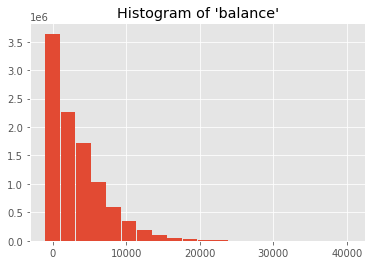

In [33]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('ggplot')
data = {
    'bins' : hists[0][:-1],
    'freq' : hists[1]
}
plt.bar(data['bins'],data['freq'],width=2000)
plt.title('Histogram of \'balance\'')

In [35]:
data_sample = fraud_df.sampleBy(
    'gender', {1: 0.0002, 2:0.0002}
).select(numerical)

In [36]:
data_sample = dict([
    (elem, data_sample.select(elem).rdd.flatMap(lambda row: row).collect())
    for elem in numerical
])
sctr = chrt.Scatter(data_multi, x='balance',y='numTrans')
chrt.show(scrt)

NameError: name 'chrt' is not defined